In [1]:
import tensorflow as tf
import numpy as np
import tf_keras
from tf_keras.layers import Dense, Activation, Dropout
import h5py
import pickle


print(tf.__version__)

2.18.0


In [2]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data_reduced.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data_reduced.zip

--2025-03-07 10:11:20--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 619961901 (591M) [application/zip]
Saving to: ‘app_data_reduced.zip’

app_data_reduced.zi 100%[===================>] 591.24M  5.03MB/s    in 1m 43s  

2025-03-07 10:13:04 (5.72 MB/s) - ‘app_data_reduced.zip’ saved [619961901/619961901]

Data decompressed successfully


In [3]:
# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)

# train set
X_train = X_train.astype('float32')
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf_keras.applications.resnet50.preprocess_input(x)

# validation set
X_valid = X_valid.astype('float32')
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = tf_keras.applications.resnet50.preprocess_input(x)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)


(array([ 968.,    0.,    0., 1264.,    0.,    0.,  491.,    0.,    0.,
         122.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

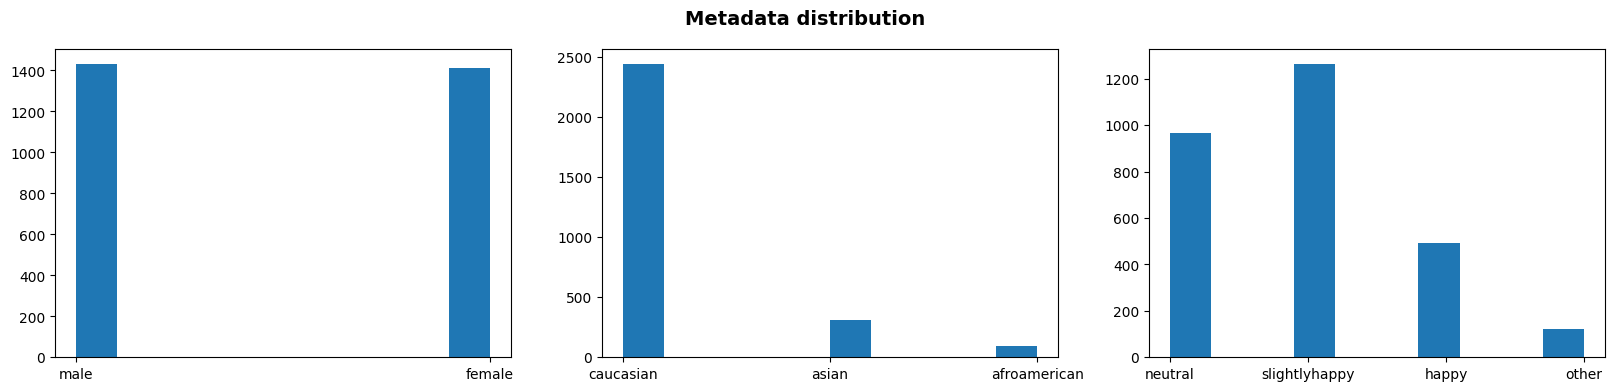

In [4]:
import matplotlib.pyplot as plt

gender = []
etnhicity = []
emotion = []
for sample in M_train:
  gender.append(sample[0])
  etnhicity.append(sample[1])
  emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(etnhicity)
ax3.hist(emotion)

(0.0, 100.0)

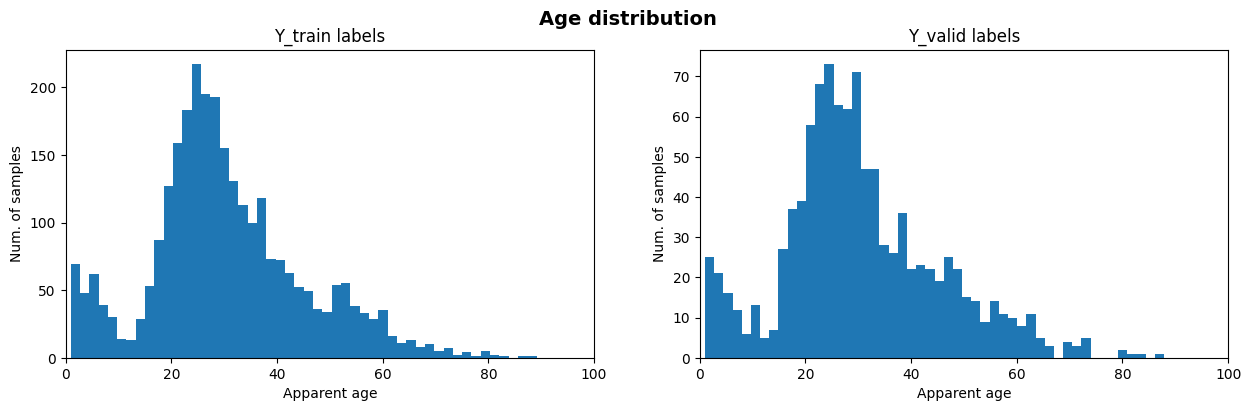

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])

In [6]:
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/vggface2_Keras.zip

# decompressing the data
with ZipFile('vggface2_Keras.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm vggface2_Keras.zip

model = tf_keras.models.load_model('vggface2_Keras.h5')

--2025-03-07 10:13:28--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/vggface2_Keras.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107894237 (103M) [application/zip]
Saving to: ‘vggface2_Keras.zip’

vggface2_Keras.zip  100%[===================>] 102.90M  5.15MB/s    in 17s     

2025-03-07 10:13:45 (6.01 MB/s) - ‘vggface2_Keras.zip’ saved [107894237/107894237]

Model decompressed successfully


ADDING 10 EXTRA LAYERS TO THE MODEL FOR 2 STAGE TRAINING

In [ ]:
import tensorflow as tf
from tf_keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tf_keras.models import Model

# Assume base_model is a pre-trained ResNet50 (VGGFace2) model already loaded.
# For example:
# base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# (In practice, use VGGFace2 pretrained weights if available.)

# Use 'dim_proj' layer output if it exists, otherwise use the base model's final output
if 'dim_proj' in [layer.name for layer in model.layers]:
    features = model.get_layer('dim_proj').output
else:
    features = model.output
    # If base_model.output is a feature map (4D tensor), apply global average pooling to flatten it
    if len(features.shape) > 2:
        features = GlobalAveragePooling2D(name='gap')(features)

# Additional fully connected layers for age prediction
x = Dense(512, activation='relu', name='f_512')(features)         # 512-unit dense layer
x = BatchNormalization(name='bn_512')(x)                          # normalize activations of f_512
x = Dropout(0.5, name='drop_512')(x)                              # dropout for regularization

x = Dense(256, activation='relu', name='f_256')(x)                # 256-unit dense layer
x = BatchNormalization(name='bn_256')(x)                          # normalize activations of f_256
x = Dropout(0.3, name='drop_256')(x)                              # dropout for regularization

x = Dense(128, activation='relu', name='f_128')(x)                # 128-unit dense layer (optional additional layer)
x = BatchNormalization(name='bn_128')(x)                          # normalize activations of f_128
x = Dropout(0.3, name='drop_128')(x)                              # dropout for regularization

# Output layer for age prediction (linear activation for regression)
age_output = Dense(1, activation='linear', name='predict')(x)

# Define the new model, with the same input as the base model and the new age output
model = Model(inputs=model.input, outputs=age_output, name='resnet50_age_model')

In [ ]:
counter = 0
for layer in model.layers:
  if counter <= 174:
    layer.trainable = False
  else:
    layer.trainable = True
  print(counter, layer.name, layer.trainable)
  counter +=1

0 base_input False
1 conv1/7x7_s2 False
2 conv1/7x7_s2/bn False
3 activation_1 False
4 max_pooling2d_1 False
5 conv2_1_1x1_reduce False
6 conv2_1_1x1_reduce/bn False
7 activation_2 False
8 conv2_1_3x3 False
9 conv2_1_3x3/bn False
10 activation_3 False
11 conv2_1_1x1_increase False
12 conv2_1_1x1_proj False
13 conv2_1_1x1_increase/bn False
14 conv2_1_1x1_proj/bn False
15 add_1 False
16 activation_4 False
17 conv2_2_1x1_reduce False
18 conv2_2_1x1_reduce/bn False
19 activation_5 False
20 conv2_2_3x3 False
21 conv2_2_3x3/bn False
22 activation_6 False
23 conv2_2_1x1_increase False
24 conv2_2_1x1_increase/bn False
25 add_2 False
26 activation_7 False
27 conv2_3_1x1_reduce False
28 conv2_3_1x1_reduce/bn False
29 activation_8 False
30 conv2_3_3x3 False
31 conv2_3_3x3/bn False
32 activation_9 False
33 conv2_3_1x1_increase False
34 conv2_3_1x1_increase/bn False
35 add_3 False
36 activation_10 False
37 conv3_1_1x1_reduce False
38 conv3_1_1x1_reduce/bn False
39 activation_11 False
40 conv3_1_3x3

In [ ]:
# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint('/content/progress/model_modified_layers_training_st1.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=1e-4),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=40, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/progress/train_history_model_modified_layers_training_st1.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/40
178/178 [==============================] - ETA: 0s - loss: 2.4719 - mae: 1.2114

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 30s 99ms/step - loss: 2.4719 - mae: 1.2114 - val_loss: 0.7618 - val_mae: 0.6120
Epoch 2/40
178/178 [==============================] - 14s 81ms/step - loss: 1.9636 - mae: 1.0581 - val_loss: 0.5681 - val_mae: 0.5033
Epoch 3/40
178/178 [==============================] - 14s 79ms/step - loss: 1.6855 - mae: 0.9760 - val_loss: 0.4599 - val_mae: 0.4175
Epoch 4/40
178/178 [==============================] - 12s 66ms/step - loss: 1.3929 - mae: 0.8816 - val_loss: 0.4078 - val_mae: 0.3813
Epoch 5/40
178/178 [==============================] - 15s 84ms/step - loss: 1.2136 - mae: 0.8068 - val_loss: 0.3618 - val_mae: 0.3337
Epoch 6/40
178/178 [==============================] - 12s 66ms/step - loss: 1.1464 - mae: 0.7802 - val_loss: 0.3362 - val_mae: 0.3107
Epoch 7/40
178/178 [==============================] - 12s 70ms/step - loss: 1.0303 - mae: 0.7362 - val_loss: 0.3108 - val_mae: 0.2801
Epoch 8/40
178/178 [==============================] - 12s 66ms/step - los

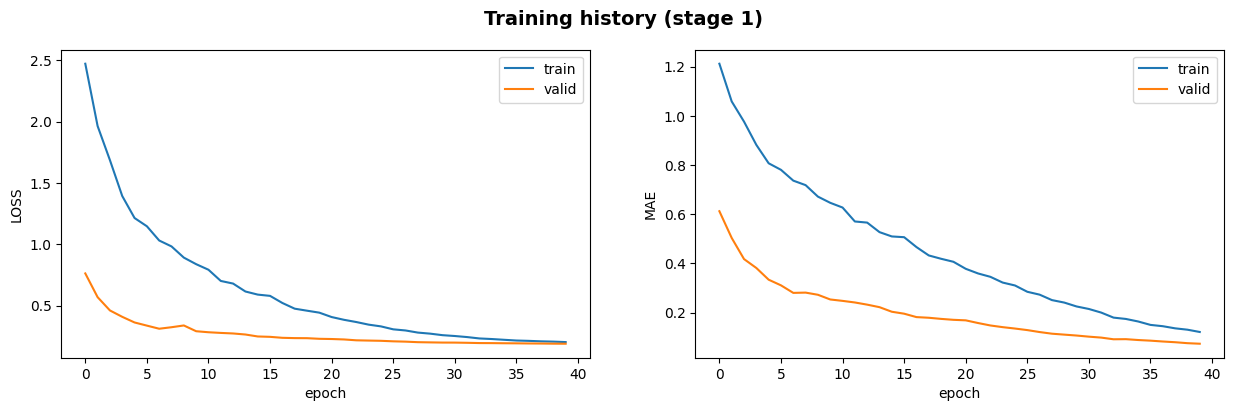

In [ ]:
train_hist = history.history

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

In [7]:
import tf_keras
import random
import cv2

# Filter for Caucasian samples (assuming they are labeled as 'caucasian')
caucasian_indices = [i for i in range(len(M_train)) if M_train[i, 1] == 'caucasian']

# Calculate how many samples to remove (40%)
num_to_remove = int(0.3 * len(caucasian_indices))

# Randomly shuffle the indices of Caucasian samples and select 40% to remove
random.shuffle(caucasian_indices)
indices_to_remove = caucasian_indices[:num_to_remove]

# Remove the selected Caucasian samples from X_train, Y_train, and M_train
X_train = np.delete(X_train, indices_to_remove, axis=0)
Y_train = np.delete(Y_train, indices_to_remove, axis=0)
M_train = np.delete(M_train, indices_to_remove, axis=0)

print(f"Number of Caucasian samples removed: {num_to_remove}")
print('Train set after augmentation = ', np.array(X_train).shape)
print('Label set after augmentation = ', np.array(Y_train).shape)


# aux variables
X_train_augmented = []
Y_train_augmented = []
M_train_augmented = []

# loading the train data and labels
print('Train set before augmentation = ', np.array(X_train).shape)

# augmenting the data
for i in range(0,len(X_train)):

  # check if image is in the group afroamerican or asian
  if M_train[i,1] == 'afroamerican':
    random_numbers = [random.randint(1, 5) for _ in range(2)]

    if 1 in random_numbers:
      # flip
      X_train_augmented.append(cv2.flip(X_train[i], 1))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 2 in random_numbers:
      # changing brightness
      x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
      x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
      X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 3 in random_numbers:
      # blur
      X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


    if 4 in random_numbers:
      #rotate 15 degrees
      rows, cols ,c= X_train[i].shape # Use X_train[i] shape for rotation
      M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
      X_train_augmented.append(cv2.warpAffine(X_train[i],M,(cols,rows))) # Append rotated image
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


  elif M_train[i, 1] == 'asian':
    random_numbers = [random.randint(1, 5) for _ in range(1)]

    if 1 in random_numbers:
      # flip
      X_train_augmented.append(cv2.flip(X_train[i], 1))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 2 in random_numbers:
      # changing brightness
      x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
      x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
      X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 3 in random_numbers:
      # blur
      X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


    if 4 in random_numbers:
      #rotate 15 degrees
      rows, cols ,c= X_train[i].shape # Use X_train[i] shape for rotation
      M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
      X_train_augmented.append(cv2.warpAffine(X_train[i],M,(cols,rows))) # Append rotated image
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


  elif Y_train[i]*100 > 50:
    random_numbers = [random.randint(1, 5) for _ in range(2)]

    if 1 in random_numbers:
      # flip
      X_train_augmented.append(cv2.flip(X_train[i], 1))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 2 in random_numbers:
      # changing brightness
      x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
      x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
      X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 3 in random_numbers:
      # blur
      X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


    if 4 in random_numbers:
      #rotate 15 degrees
      rows, cols ,c= X_train[i].shape # Use X_train[i] shape for rotation
      M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
      X_train_augmented.append(cv2.warpAffine(X_train[i],M,(cols,rows))) # Append rotated image
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train = np.concatenate((M_train, M_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)
del X_train_augmented, Y_train_augmented, M_train_augmented


#=================================================================
# post-processing the train data with respect to ResNet-50 Inputs.
#=================================================================
# train set
X_train = X_train.astype('float32')
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf_keras.applications.resnet50.preprocess_input(x)

Number of Caucasian samples removed: 732
Train set after augmentation =  (2113, 224, 224, 3)
Label set after augmentation =  (2113,)
Train set before augmentation =  (2113, 224, 224, 3)
Train set after augmentation =  (2829, 224, 224, 3)


In [ ]:
model.trainable = True

for layer in model.layers:
  print(counter, layer.name, layer.trainable)

186 base_input True
186 conv1/7x7_s2 True
186 conv1/7x7_s2/bn True
186 activation_1 True
186 max_pooling2d_1 True
186 conv2_1_1x1_reduce True
186 conv2_1_1x1_reduce/bn True
186 activation_2 True
186 conv2_1_3x3 True
186 conv2_1_3x3/bn True
186 activation_3 True
186 conv2_1_1x1_increase True
186 conv2_1_1x1_proj True
186 conv2_1_1x1_increase/bn True
186 conv2_1_1x1_proj/bn True
186 add_1 True
186 activation_4 True
186 conv2_2_1x1_reduce True
186 conv2_2_1x1_reduce/bn True
186 activation_5 True
186 conv2_2_3x3 True
186 conv2_2_3x3/bn True
186 activation_6 True
186 conv2_2_1x1_increase True
186 conv2_2_1x1_increase/bn True
186 add_2 True
186 activation_7 True
186 conv2_3_1x1_reduce True
186 conv2_3_1x1_reduce/bn True
186 activation_8 True
186 conv2_3_3x3 True
186 conv2_3_3x3/bn True
186 activation_9 True
186 conv2_3_1x1_increase True
186 conv2_3_1x1_increase/bn True
186 add_3 True
186 activation_10 True
186 conv3_1_1x1_reduce True
186 conv3_1_1x1_reduce/bn True
186 activation_11 True
186 

In [ ]:
# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint('/content/progress/model_modified_layers_training_st2.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=1e-4),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/progress/train_history_model_modified_layers_training_st2.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/30
177/177 [==============================] - ETA: 0s - loss: 0.2029 - mae: 0.1221

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/177 [==============================] - 71s 236ms/step - loss: 0.2029 - mae: 0.1221 - val_loss: 0.2015 - val_mae: 0.1158
Epoch 2/30
177/177 [==============================] - 36s 204ms/step - loss: 0.1978 - mae: 0.1122 - val_loss: 0.2177 - val_mae: 0.1583
Epoch 3/30
177/177 [==============================] - 35s 200ms/step - loss: 0.1919 - mae: 0.1039 - val_loss: 0.5608 - val_mae: 0.5676
Epoch 4/30
177/177 [==============================] - 39s 218ms/step - loss: 0.1853 - mae: 0.0977 - val_loss: 0.1974 - val_mae: 0.1365
Epoch 5/30
177/177 [==============================] - 39s 217ms/step - loss: 0.1778 - mae: 0.0870 - val_loss: 0.1727 - val_mae: 0.0767
Epoch 6/30
177/177 [==============================] - 44s 246ms/step - loss: 0.1707 - mae: 0.0826 - val_loss: 0.1655 - val_mae: 0.0720
Epoch 7/30
177/177 [==============================] - 46s 261ms/step - loss: 0.1632 - mae: 0.0785 - val_loss: 0.1593 - val_mae: 0.0733
Epoch 8/30
177/177 [==============================] - 69s 389ms/st

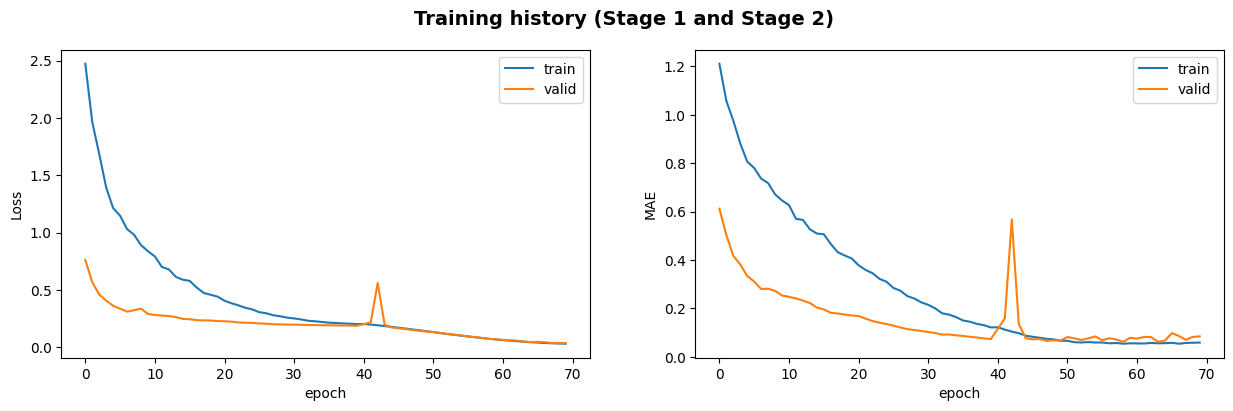

In [ ]:
train_hist = pickle.load(open("/content/progress/train_history_model_modified_layers_training_st1.pkl","rb"))
train_hist_2nd = pickle.load(open("/content/progress/train_history_model_modified_layers_training_st2.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

In [ ]:
# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

#=================================================================
# post-processing the test data with respect to ResNet-50 Inputs.
#=================================================================
# test set
X_test = X_test.astype('float32')
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf_keras.applications.resnet50.preprocess_input(x)

print('----')
print('Test data size and shape', X_test.shape)

----
Test data size and shape (1978, 224, 224, 3)


In [ ]:
predictions_model_st2_aug_valid = model.predict(X_valid, batch_size=16, verbose=1)
predictions_model_st2_aug_test = model.predict(X_test, batch_size=16, verbose=1)

124/124 [==============================] - 6s 46ms/step


In [18]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

--2025-03-07 10:40:10--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4355 (4.3K) [application/octet-stream]
Saving to: ‘bias_functions.py’

bias_functions.py   100%[===================>]   4.25K  --.-KB/s    in 0s      

2025-03-07 10:40:10 (401 MB/s) - ‘bias_functions.py’ saved [4355/4355]



In [ ]:
# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# computing the age bias (model_stage_2)
age_bias(predictions_model_st2_aug_valid,Y_valid*100)
age_bias(predictions_model_st2_aug_test,Y_test)

# computing the gender bias (model_stage_2)
gender_bias(predictions_model_st2_aug_valid,Y_valid*100,M_valid)
gender_bias(predictions_model_st2_aug_test,Y_test,M_test)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_model_st2_aug_valid,Y_valid*100,M_valid)
ethnicity_bias(predictions_model_st2_aug_test,Y_test,M_test)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_model_st2_aug_valid,Y_valid*100,M_valid)
face_expression_bias(predictions_model_st2_aug_test,Y_test,M_test)

Age analysis:
Size group 1 = 205, MAE = 11.434542
Size group 2 = 590, MAE = 28.055717
Size group 3 = 197, MAE = 47.923168
Size group 4 = 45, MAE = 66.793884
---------
Age bias (Ba) =  30.99091339111328
Age analysis:
Size group 1 = 369, MAE = 8.757215
Size group 2 = 1044, MAE = 29.363663
Size group 3 = 390, MAE = 48.013977
Size group 4 = 175, MAE = 69.526367
---------
Age bias (Ba) =  33.49296315511068
Gender analysis:
Size group female = 497, MAE = 27.525654
Size group male = 540, MAE = 32.709797
---------
Gender bias (Bg) =  5.184143
Gender analysis:
Size group female = 1020, MAE = 30.809895
Size group male = 958, MAE = 34.815815
---------
Gender bias (Bg) =  4.0059204
Ethnicity Analysis:
Size group asian = 79, MAE = 26.895145
Size group afroamerican = 32, MAE = 28.047867
Size group caucasian = 926, MAE = 30.584549
---------
Ethnicity bias (Be) =  2.4596023559570312
Ethnicity Analysis:
Size group asian = 129, MAE = 26.514330
Size group afroamerican = 56, MAE = 30.077625
Size group cau

In [ ]:
model = tf_keras.models.load_model('progress/model_modified_layers_training_st2.h5')
predictions_model_st2_aug_test = model.predict(X_test, batch_size=16, verbose=1)

124/124 [==============================] - 8s 41ms/step


In [ ]:
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_model_st2_aug_test[i][0]*100,Y_test[i])))
print('MAE (model stage 1, test set) = %.8f' %(np.mean(error)))

MAE (model stage 1, test set) = 9.85469003


In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_model_st2_aug_test)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions_st2-test-set.zip predictions.csv

  adding: predictions.csv (deflated 61%)


## Augmenting

In [8]:
import tf_keras
import random
import cv2

# Filter for Caucasian samples (assuming they are labeled as 'caucasian')
caucasian_indices = [i for i in range(len(M_train)) if M_train[i, 1] == 'caucasian']

# Calculate how many samples to remove (40%)
num_to_remove = int(0.3 * len(caucasian_indices))

# Randomly shuffle the indices of Caucasian samples and select 40% to remove
random.shuffle(caucasian_indices)
indices_to_remove = caucasian_indices[:num_to_remove]

# Remove the selected Caucasian samples from X_train, Y_train, and M_train
X_train = np.delete(X_train, indices_to_remove, axis=0)
Y_train = np.delete(Y_train, indices_to_remove, axis=0)
M_train = np.delete(M_train, indices_to_remove, axis=0)

print(f"Number of Caucasian samples removed: {num_to_remove}")
print('Train set after augmentation = ', np.array(X_train).shape)
print('Label set after augmentation = ', np.array(Y_train).shape)


# aux variables
X_train_augmented = []
Y_train_augmented = []
M_train_augmented = []

# loading the train data and labels
print('Train set before augmentation = ', np.array(X_train).shape)

# augmenting the data
for i in range(0,len(X_train)):

  # check if image is in the group afroamerican or asian
  if M_train[i,1] == 'afroamerican':
    random_numbers = [random.randint(1, 5) for _ in range(2)]

    if 1 in random_numbers:
      # flip
      X_train_augmented.append(cv2.flip(X_train[i], 1))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 2 in random_numbers:
      # changing brightness
      x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
      x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
      X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 3 in random_numbers:
      # blur
      X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


    if 4 in random_numbers:
      #rotate 15 degrees
      rows, cols ,c= X_train[i].shape # Use X_train[i] shape for rotation
      M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
      X_train_augmented.append(cv2.warpAffine(X_train[i],M,(cols,rows))) # Append rotated image
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


  elif M_train[i, 1] == 'asian':
    random_numbers = [random.randint(1, 5) for _ in range(1)]

    if 1 in random_numbers:
      # flip
      X_train_augmented.append(cv2.flip(X_train[i], 1))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 2 in random_numbers:
      # changing brightness
      x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
      x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
      X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 3 in random_numbers:
      # blur
      X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


    if 4 in random_numbers:
      #rotate 15 degrees
      rows, cols ,c= X_train[i].shape # Use X_train[i] shape for rotation
      M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
      X_train_augmented.append(cv2.warpAffine(X_train[i],M,(cols,rows))) # Append rotated image
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


  elif Y_train[i]*100 > 60:
    random_numbers = [random.randint(1, 5) for _ in range(2)]

    if 1 in random_numbers:
      # flip
      X_train_augmented.append(cv2.flip(X_train[i], 1))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 2 in random_numbers:
      # changing brightness
      x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
      x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
      X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

    if 3 in random_numbers:
      # blur
      X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])


    if 4 in random_numbers:
      #rotate 15 degrees
      rows, cols ,c= X_train[i].shape # Use X_train[i] shape for rotation
      M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
      X_train_augmented.append(cv2.warpAffine(X_train[i],M,(cols,rows))) # Append rotated image
      Y_train_augmented.append(Y_train[i])
      M_train_augmented.append(M_train[i])

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train = np.concatenate((M_train, M_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)
del X_train_augmented, Y_train_augmented, M_train_augmented


#=================================================================
# post-processing the train data with respect to ResNet-50 Inputs.
#=================================================================
# train set
X_train = X_train.astype('float32')
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf_keras.applications.resnet50.preprocess_input(x)

Number of Caucasian samples removed: 611
Train set after augmentation =  (2218, 224, 224, 3)
Label set after augmentation =  (2218,)
Train set before augmentation =  (2218, 224, 224, 3)
Train set after augmentation =  (3149, 224, 224, 3)


In [9]:
import numpy as np
import random

(array([1372.,    0.,    0., 1121.,    0.,    0.,  535.,    0.,    0.,
         121.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

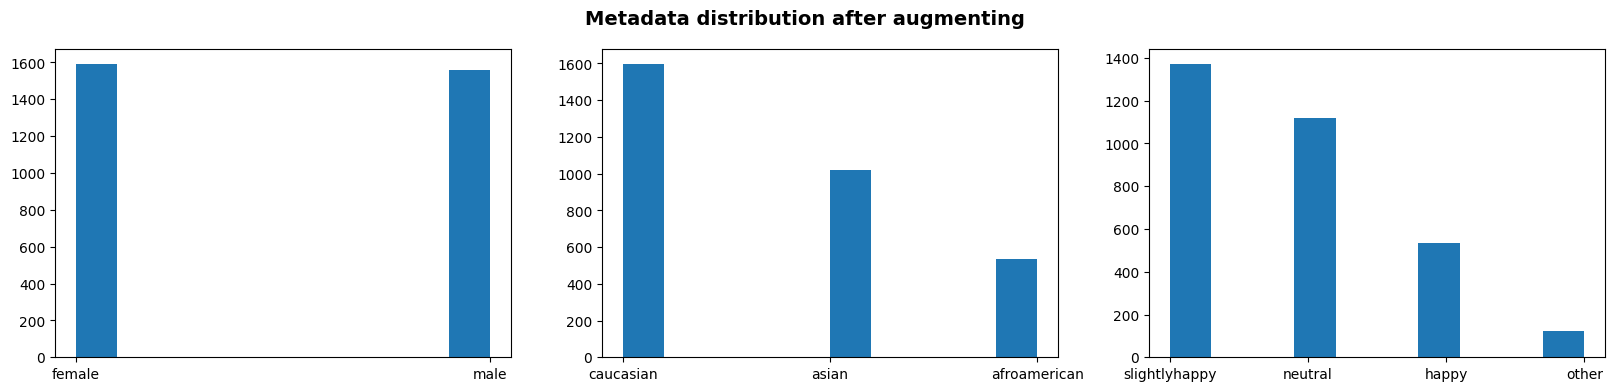

In [10]:
gender = []
etnhicity = []
emotion = []
for sample in M_train:
  gender.append(sample[0])
  etnhicity.append(sample[1])
  emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution after augmenting', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(etnhicity)
ax3.hist(emotion)

(0.0, 100.0)

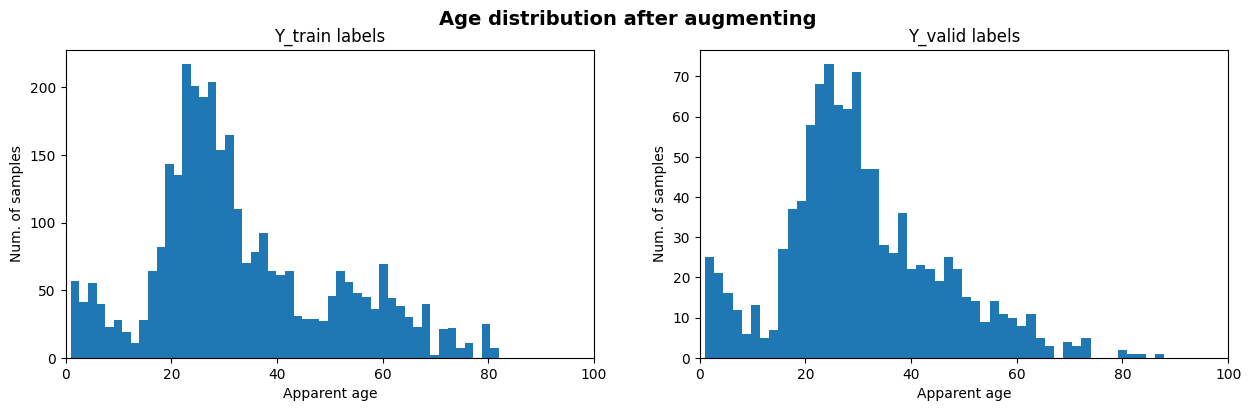

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution after augmenting', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])

In [12]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/vggface2_Keras.zip

# decompressing the data
with ZipFile('vggface2_Keras.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm vggface2_Keras.zip

model = tf_keras.models.load_model('vggface2_Keras.h5')

# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# adding a dropout layer to minimize overfiting problems
dp_layer = tf_keras.layers.Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
fc_128 = tf_keras.layers.Dense(128, activation='relu', name='f_128')(dp_layer)
fc_32 = tf_keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = tf_keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

# building and pringing the final model
model = tf_keras.models.Model(inputs=model.get_layer('base_input').output,outputs=output)

model.trainable = True

--2025-03-07 10:15:31--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/vggface2_Keras.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107894237 (103M) [application/zip]
Saving to: ‘vggface2_Keras.zip’

vggface2_Keras.zip  100%[===================>] 102.90M  8.53MB/s    in 13s     

2025-03-07 10:15:45 (7.66 MB/s) - ‘vggface2_Keras.zip’ saved [107894237/107894237]

Model decompressed successfully


In [ ]:
# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint('/content/progress/model_full_training_aug.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=1e-4),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/progress/train_history_model_full_training_aug.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 0.3425 - mae: 0.3492

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 79s 501ms/step - loss: 0.3425 - mae: 0.3492 - val_loss: 0.2922 - val_mae: 0.3023
Epoch 2/30
81/81 [==============================] - 36s 446ms/step - loss: 0.2695 - mae: 0.2699 - val_loss: 0.2667 - val_mae: 0.2680
Epoch 3/30
81/81 [==============================] - 33s 412ms/step - loss: 0.2182 - mae: 0.1613 - val_loss: 0.2527 - val_mae: 0.2427
Epoch 4/30
81/81 [==============================] - 37s 453ms/step - loss: 0.1906 - mae: 0.0858 - val_loss: 0.1886 - val_mae: 0.0775
Epoch 5/30
81/81 [==============================] - 39s 478ms/step - loss: 0.1840 - mae: 0.0656 - val_loss: 0.1840 - val_mae: 0.0667
Epoch 6/30
81/81 [==============================] - 33s 410ms/step - loss: 0.1807 - mae: 0.0579 - val_loss: 0.1809 - val_mae: 0.0625
Epoch 7/30
81/81 [==============================] - 34s 416ms/step - loss: 0.1781 - mae: 0.0524 - val_loss: 0.1800 - val_mae: 0.0628
Epoch 8/30
81/81 [==============================] - 43s 530ms/step - loss: 0.175

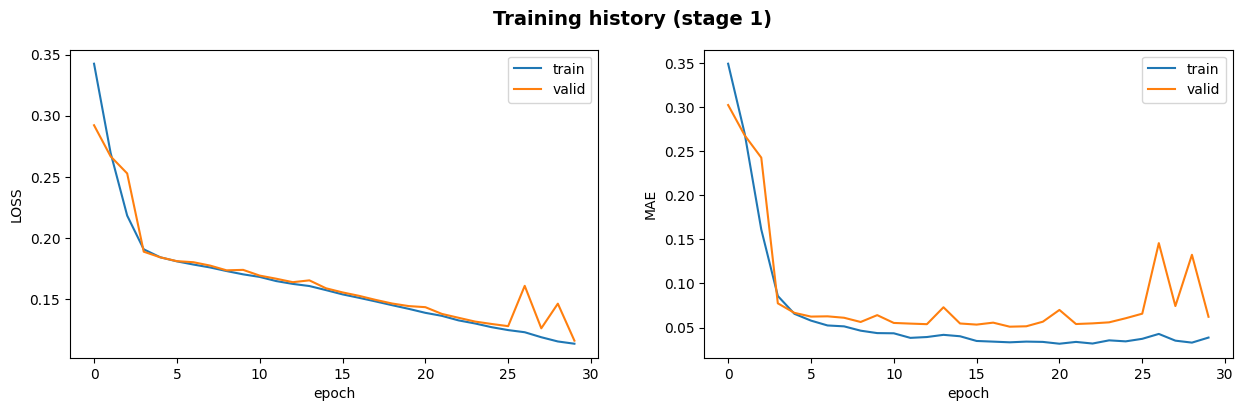

In [ ]:
train_hist = pickle.load(open("/content/progress/train_history_model_full_training_aug.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

In [ ]:
# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

#=================================================================
# post-processing the test data with respect to ResNet-50 Inputs.
#=================================================================
# test set
X_test = X_test.astype('float32')
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf_keras.applications.resnet50.preprocess_input(x)

print('----')
print('Test data size and shape', X_test.shape)

----
Test data size and shape (1978, 224, 224, 3)


In [ ]:
predictions_model_full_training_aug_valid = model.predict(X_valid, batch_size=16, verbose=1)
predictions_model_full_training_aug_test = model.predict(X_test, batch_size=16, verbose=1)

124/124 [==============================] - 6s 46ms/step


In [ ]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

--2025-03-07 08:07:57--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4355 (4.3K) [application/octet-stream]
Saving to: ‘bias_functions.py’

bias_functions.py   100%[===================>]   4.25K  --.-KB/s    in 0s      

2025-03-07 08:07:58 (498 MB/s) - ‘bias_functions.py’ saved [4355/4355]



In [ ]:
# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# computing the age bias (model_stage_2)
age_bias(predictions_model_full_training_aug_valid,Y_valid*100)
age_bias(predictions_model_full_training_aug_test,Y_test)

# computing the gender bias (model_stage_2)
gender_bias(predictions_model_full_training_aug_valid,Y_valid*100,M_valid)
gender_bias(predictions_model_full_training_aug_test,Y_test,M_test)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_model_full_training_aug_valid,Y_valid*100,M_valid)
ethnicity_bias(predictions_model_full_training_aug_test,Y_test,M_test)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_model_full_training_aug_valid,Y_valid*100,M_valid)
face_expression_bias(predictions_model_full_training_aug_test,Y_test,M_test)

Age analysis:
Size group 1 = 205, MAE = 11.509801
Size group 2 = 590, MAE = 28.096081
Size group 3 = 197, MAE = 47.912853
Size group 4 = 45, MAE = 66.725273
---------
Age bias (Ba) =  30.910532633463543
Age analysis:
Size group 1 = 369, MAE = 8.838912
Size group 2 = 1044, MAE = 29.396286
Size group 3 = 390, MAE = 48.010277
Size group 4 = 175, MAE = 69.469475
---------
Age bias (Ba) =  33.41761271158854
Gender analysis:
Size group female = 497, MAE = 27.564201
Size group male = 540, MAE = 32.737518
---------
Gender bias (Bg) =  5.173317
Gender analysis:
Size group female = 1020, MAE = 30.836092
Size group male = 958, MAE = 34.843040
---------
Gender bias (Bg) =  4.0069485
Ethnicity Analysis:
Size group asian = 79, MAE = 26.934769
Size group afroamerican = 32, MAE = 28.095032
Size group caucasian = 926, MAE = 30.616394
---------
Ethnicity bias (Be) =  2.4544169108072915
Ethnicity Analysis:
Size group asian = 129, MAE = 26.554989
Size group afroamerican = 56, MAE = 30.127573
Size group ca

In [ ]:
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_model_full_training_aug_test[i][0]*100,Y_test[i])))
print('MAE (model stage 1, test set) = %.8f' %(np.mean(error)))

MAE (model stage 1, test set) = 7.76556253


In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_model_full_training_aug_test)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions_full_training-test-set.zip predictions.csv

  adding: predictions.csv (deflated 60%)


# Training in two stages with example extra 5 layers to the model

In [13]:

import pickle

# load a model and train history
#--------------------------
LOAD_BEST_MODEL_ST1 = True # (training only the last FC layers)
#--------------------------


if(LOAD_BEST_MODEL_ST1==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024/best_model_st1.zip
  # decompressing the data
  with ZipFile('best_model_st1.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st1.zip
  train_hist = pickle.load(open("train_history.pkl","rb"))


--2025-03-07 10:21:10--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024/best_model_st1.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99955754 (95M) [application/zip]
Saving to: ‘best_model_st1.zip’

best_model_st1.zip  100%[===================>]  95.33M  5.90MB/s    in 16s     

2025-03-07 10:21:26 (6.03 MB/s) - ‘best_model_st1.zip’ saved [99955754/99955754]

Model decompressed successfully


In [14]:
 # loading the saved model (best model learned at stage 1)
saved_model = tf_keras.models.load_model('/content/best_model.h5')

# setting all layers to traineble
saved_model.trainable = True

# training all layers (2nd stage), given the model saved on stage 1
saved_model.compile(tf_keras.optimizers.Adam(learning_rate=1e-4),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# saving the best model (2nd stage) based on val_loss with a different name
mc = tf_keras.callbacks.ModelCheckpoint('/content/best_model_two_stages.h5', monitor='val_loss', mode='min', save_best_only=True)

history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history
with open('/content/train_history_two_stages.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/30
197/197 [==============================] - ETA: 0s - loss: 0.1834 - mae: 0.0657

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 69s 200ms/step - loss: 0.1834 - mae: 0.0657 - val_loss: 0.1908 - val_mae: 0.1121
Epoch 2/30
197/197 [==============================] - 37s 189ms/step - loss: 0.1653 - mae: 0.0431 - val_loss: 0.2181 - val_mae: 0.2050
Epoch 3/30
197/197 [==============================] - 42s 214ms/step - loss: 0.1482 - mae: 0.0370 - val_loss: 0.1526 - val_mae: 0.0902
Epoch 4/30
197/197 [==============================] - 37s 189ms/step - loss: 0.1307 - mae: 0.0313 - val_loss: 0.1346 - val_mae: 0.0845
Epoch 5/30
197/197 [==============================] - 38s 192ms/step - loss: 0.1152 - mae: 0.0339 - val_loss: 0.1578 - val_mae: 0.1799
Epoch 6/30
197/197 [==============================] - 44s 222ms/step - loss: 0.1080 - mae: 0.0564 - val_loss: 0.1212 - val_mae: 0.1232
Epoch 7/30
197/197 [==============================] - 36s 181ms/step - loss: 0.0951 - mae: 0.0414 - val_loss: 0.1410 - val_mae: 0.1961
Epoch 8/30
197/197 [==============================] - 43s 217ms/st

In [15]:
predictions_model_two_stages_aug_valid = saved_model.predict(X_valid, batch_size=32, verbose=1)

33/33 [==============================] - 4s 72ms/step


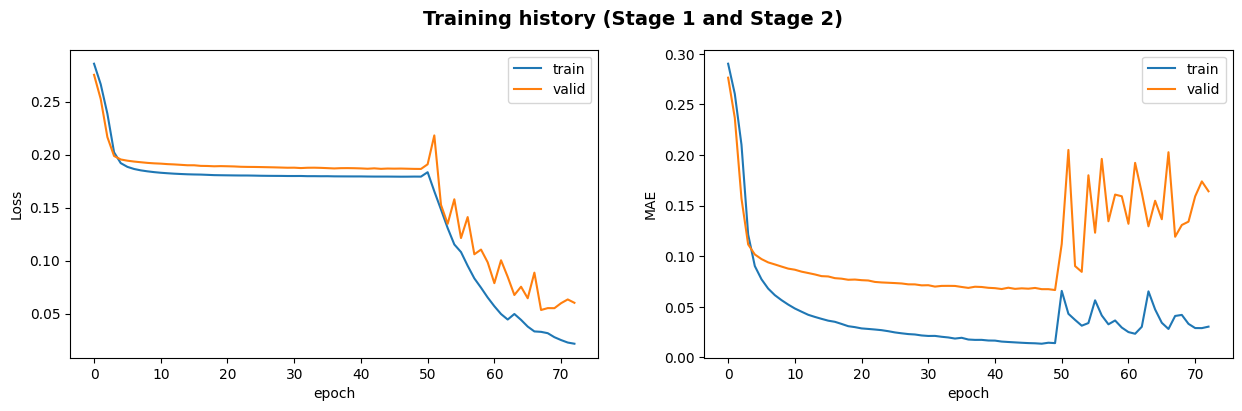

In [16]:
train_hist_2nd = pickle.load(open("/content/train_history_two_stages.pkl","rb"))
train_hist = pickle.load(open("/content/train_history.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

In [19]:
# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# computing the age bias (model_stage_2)
age_bias(predictions_model_two_stages_aug_valid,Y_valid*100)

# computing the gender bias (model_stage_2)
gender_bias(predictions_model_two_stages_aug_valid,Y_valid*100,M_valid)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_model_two_stages_aug_valid,Y_valid*100,M_valid)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_model_two_stages_aug_valid,Y_valid*100,M_valid)

Age analysis:
Size group 1 = 205, MAE = 11.306407
Size group 2 = 590, MAE = 27.938734
Size group 3 = 197, MAE = 47.773468
Size group 4 = 45, MAE = 66.676559
---------
Age bias (Ba) =  30.990865071614582
Gender analysis:
Size group female = 497, MAE = 27.420664
Size group male = 540, MAE = 32.565586
---------
Gender bias (Bg) =  5.1449223
Ethnicity Analysis:
Size group asian = 79, MAE = 26.816307
Size group afroamerican = 32, MAE = 28.000322
Size group caucasian = 926, MAE = 30.452471
---------
Ethnicity bias (Be) =  2.424109141031901
Face experession Analysis:
Size group happy = 298, MAE = 29.649912
Size group slightlyhappy = 311, MAE = 30.584894
Size group neutral = 351, MAE = 30.894058
Size group other = 77, MAE = 26.261000
---------
Face Expression bias (Bf) =  2.4723596572875977


In [20]:
# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

#=================================================================
# post-processing the test data with respect to ResNet-50 Inputs.
#=================================================================
# test set
X_test = X_test.astype('float32')
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf_keras.applications.resnet50.preprocess_input(x)

print('----')
print('Test data size and shape', X_test.shape)

----
Test data size and shape (1978, 224, 224, 3)


In [21]:
predictions_model_two_stages_aug_test = saved_model.predict(X_test, batch_size=32, verbose=1)

62/62 [==============================] - 6s 88ms/step


In [22]:
# computing the age bias (model_stage_2)
age_bias(predictions_model_two_stages_aug_test,Y_test)

# computing the gender bias (model_stage_2)
gender_bias(predictions_model_two_stages_aug_test,Y_test,M_test)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_model_two_stages_aug_test,Y_test,M_test)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_model_two_stages_aug_test,Y_test,M_test)

Age analysis:
Size group 1 = 369, MAE = 8.614465
Size group 2 = 1044, MAE = 29.257812
Size group 3 = 390, MAE = 47.861076
Size group 4 = 175, MAE = 69.390213
---------
Age bias (Ba) =  33.48841857910156
Gender analysis:
Size group female = 1020, MAE = 30.701923
Size group male = 958, MAE = 34.673317
---------
Gender bias (Bg) =  3.9713936
Ethnicity Analysis:
Size group asian = 129, MAE = 26.448450
Size group afroamerican = 56, MAE = 30.050318
Size group caucasian = 1793, MAE = 33.150215
---------
Ethnicity bias (Be) =  4.467843373616536
Face experession Analysis:
Size group happy = 589, MAE = 31.503826
Size group slightlyhappy = 505, MAE = 33.154510
Size group neutral = 756, MAE = 33.702888
Size group other = 128, MAE = 29.334681
---------
Face Expression bias (Bf) =  2.4592180252075195


In [24]:
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_model_two_stages_aug_test[i][0]*100,Y_test[i])))
print('MAE (model stage 1, test set) = %.8f' %(np.mean(error)))

MAE (model stage 1, test set) = 15.83430067


In [27]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_model_two_stages_aug_test)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions_st2-test-set.zip predictions.csv

  adding: predictions.csv (deflated 60%)
